## Demo: compare memory usage of three different modes
This Notebook compares the memory profile and the performance of three different modes of `run_threads`. 

In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np 
import logging 
import sys 
import cgc

from memory_profiler import memory_usage

from cgc.coclustering_numpy import coclustering

logging.basicConfig(level=logging.INFO, stream=sys.stdout, format="%(asctime)-15s %(levelname)-5s - %(message)s")

In [2]:
# Set up plotting functions

def _initialize_clusters(n_el, n_clusters):
    """ Initialize cluster occupation matrix """
    cluster_idx = np.mod(np.arange(n_el), n_clusters)
    # cluster_idx = np.random.permutation(cluster_idx)
    return cluster_idx

def plot(memory):
    """ Plot memory usage vs time """
    plt.plot(np.array(memory) - memory[0])
    plt.xlabel('Time step')
    plt.ylabel('Memory / MB')
    plt.show()
    
def profile(f, Z, input):
    # benchmark timing
    %timeit _ = f(Z, **input)
    # compute memory usage and plot it
    (memory, (conv, iters, r, c, e)) = memory_usage((f, (Z,), input), 
                                                    interval=0.01, 
                                                    retval=True)
    plot(memory)
    # print output
    print(r, c, e)

In [3]:
Z = np.random.randint(100, size=(500000, 50)).astype('float64') 
k = 250; l = 10
print('size of Z = {} MB'.format(Z.nbytes/ 1024**2))
print('size of R = {} MB'.format(Z.dtype.itemsize * Z.shape[0] * k / 1024**2))
print('size of C = {} MB'.format(Z.dtype.itemsize * Z.shape[1] * l / 1024**2))

size of Z = 190.73486328125 MB
size of R = 953.67431640625 MB
size of C = 0.003814697265625 MB


In [4]:
(m, n) = Z.shape
row_clusters = _initialize_clusters(m, k)
col_clusters = _initialize_clusters(n, l)

In [5]:
input = {'nclusters_row':k, 
         'nclusters_col':l, 
         'errobj':1.e-5, 
         'niters':5, 
         'epsilon':1.e-8,
         'row_clusters_init': row_clusters,
         'col_clusters_init': col_clusters,}

### Mode 1: normal run
In this mode the memory usage is high due to the usage of many large matrix, such as `R` and `C`. However we can perform matric multiplication directly so the performance is high.

29.5 s ± 10.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


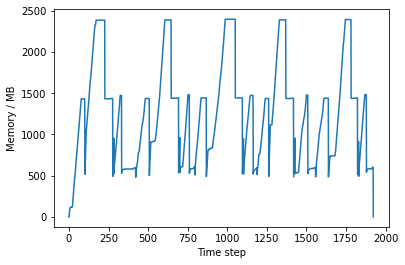

[ 85  25  72 ... 206 143 234] [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9] -3616954286.004359


In [6]:
input['low_memory'] = False
input['numba_jit'] = False
f = coclustering
profile(f, Z, input)

### Mode 2: low memory run
In this mode the memory usage is significantly reduced by:
1. replacing large matrix multiplication by for loops
2. avoid saving full results of distance fanction, but use for loop to get the min distance value

In this way thememory usage is significantly reduced. However we sacrifice the performance.

31.4 s ± 1.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


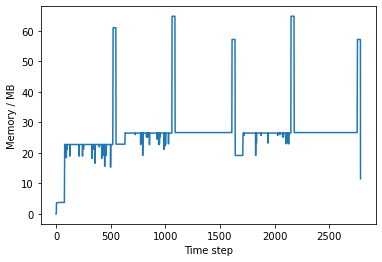

[ 85  25  72 ... 206 143 234] [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9] -3616954286.0043306


In [7]:
input['low_memory'] = True
input['numba_jit'] = False
f = coclustering
profile(f, Z, input)

### Mode 3: low memory run with numba acceleration
In this mode: we still use the low memery configuration, but use `Numba` toaccelerate the for loops.

26.9 s ± 2.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


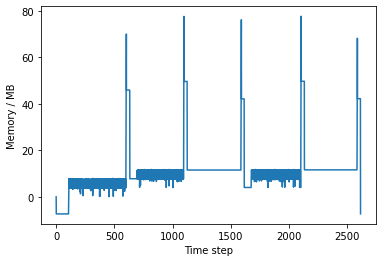

[ 85  25  72 ... 206 143 234] [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9] -3616954286.0043306


In [8]:
input['low_memory'] = True
input['numba_jit'] = True
f = coclustering
profile(f, Z, input)